In [4]:
skin_types = {
    1042: ["Male", 2], # asian
    1172: ["Male", 2], # asian
    1302: ["Female", 2], # asian
    132: ["Male", 3],
    1562: ["Male", 3],
    1692: ["Female", 3],
    1952: ["Male", 3], # blue cap
    2: ["Male", 2],
    2082: ["Male", 5],
    2212: ["Male", 3],
    2342: ["Female", 3],
    2472: ["Female", 4],
    2602: ["Female", 2], #asian
    262: ["Male", 5], #asian
    2732: ["Female", 2],
    2862: ["Female", 4],
    2992: ["Female", 2],
    3122: ["Female", 3],
    3382: ["Male", 3],
    3512: ["Female", 3],
    3642: ["Female", 1],
    3772: ["Male", 1],
    3642: ["Female", 3],
    524: ["Female", 4],
    652: ["Female", 4],
    782: ["Female", 2], # asian
    912: ["Male", 2]
}

In [5]:
len(skin_types)

26

In [82]:
import sys
sys.path += ["/Users/yousuf/Workspace/dissertation/code/rPPG/python/core/"]
import helper
import pandas as pd
PATH = "/Users/yousuf/Workspace/dissertation/code/rPPG/output/hr_evaluation/"

## Face tracking

In [ ]:
face_tr = pd.read_csv(PATH + "face_track")

## Relationship between error and noise

Index(['Video', 'Tracker', 'Region selector', 'Window size', 'Offset size',
       'Heart Rate Number', 'Framerate', 'rPPG HR ICA', 'rPPG HR MV',
       'PPG HR BC', 'PPG HR FFT', 'ECG HR BC', 'ECG HR FFT', 'ICA 1 HR',
       'ICA 1 Power', 'ICA 1 BC', 'Noise 1', 'SelfD Noise 1', 'ICA 2 HR',
       'ICA 2 Power', 'ICA 2 BC', 'Noise 2', 'SelfD Noise 2', 'ICA 3 HR',
       'ICA 3 Power', 'ICA 3 BC', 'Noise 3', 'SelfD Noise 3'],
      dtype='object')


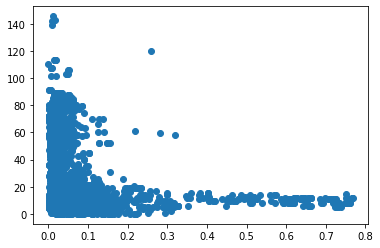

In [312]:
data = pd.read_csv(PATH + "sp_output_15_03_20(6).csv")
print(data.columns)
str_cols = ["Video", "Tracker", "Region selector"]
num_cols = [c for c in data.columns if c not in str_cols]
for c in num_cols:
    data[c] = pd.to_numeric(data[c], errors='coerce')
# data["Error"] = np.abs(data["rPPG HR MV"]-data["ECG HR BC"])
data["Error"] = np.abs(data["rPPG HR ICA"]-data["ECG HR BC"])
types = ["Stationary", "Jogging", "Star jumps"]
data["Type"] = ["Stationary" if "stat" in s else "Jogging" if "jog" in s else "Star jumps" for s in data["Video"]]
for i in range(1,4):
    cols = data["rPPG HR ICA"] == data[f"ICA {i} HR"]
    data.loc[cols,"Noise"] = data.loc[cols][f"Noise {i}"] 
    data.loc[cols,"SelfNoise"] = data.loc[cols][f"SelfD Noise {i}"]
plt.scatter(data["Noise 1"], data["Error"])

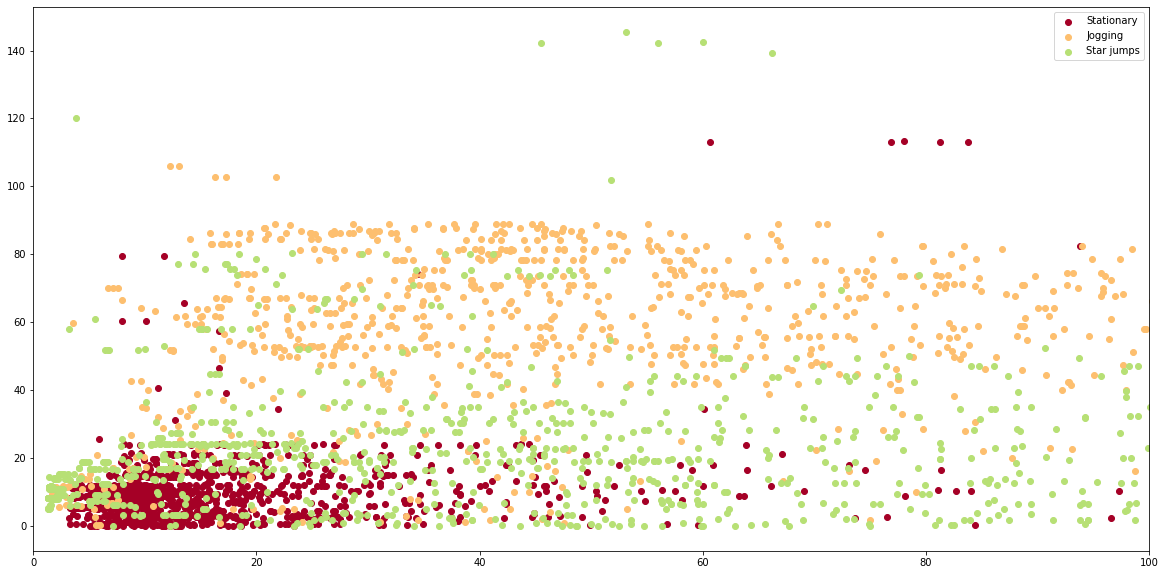

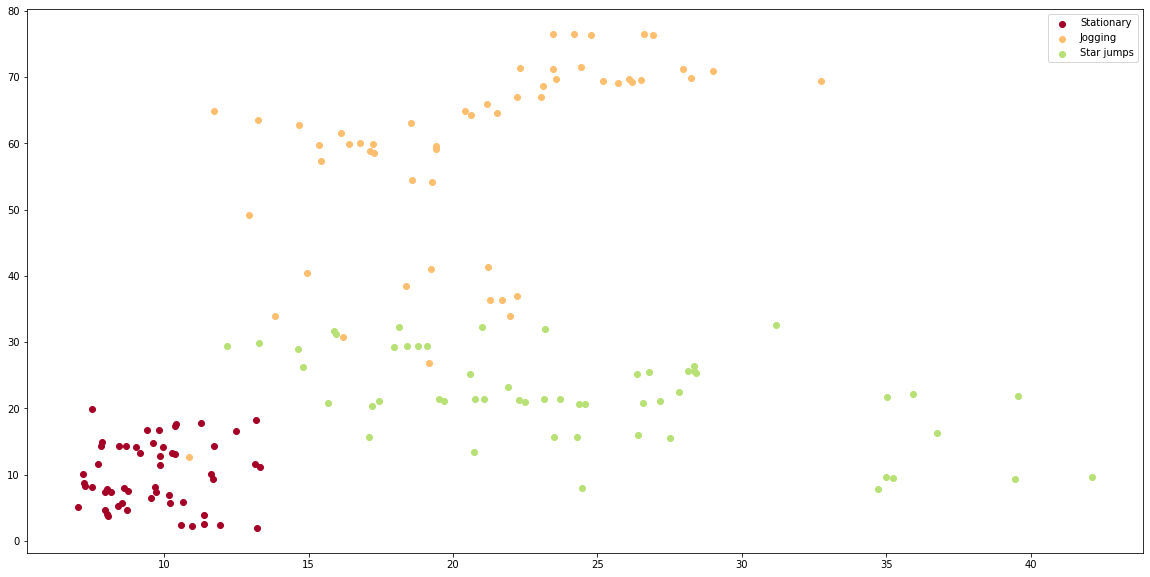

In [313]:
import matplotlib.cm as cm
distances = [1, 1.5, 2]
fig, ax = plt.subplots(figsize=(20,10))
cut = data[data["Framerate"]==30]
grouped = data.groupby(by=["Video", "Framerate"]).agg(np.mean)
videos = [grouped.index[i][0] for i in range(len(grouped.index))]
grouped["Type"] = ["Stationary" if "stat" in s else "Jogging" if "jog" in s else "Star jumps" for s in videos]
grouped["Distance"] = [1 if "1_" in s else 1.5 if "1.5_" in s else 2 for s in videos]
cmap = cm.get_cmap("RdYlGn")
for i,t in enumerate(types):
#     for j,d in enumerate(distances):
#         rel = grouped[(grouped["Type"] == t)&(grouped["Distance"]==d)]
#     rel = grouped[(grouped["Type"]==t)]
    rel = data[data["Type"] == t]
    col = (i*3)+j
    ax.scatter(rel["Noise"]**-1, rel["Error"], label=f"{t}", color=cmap(i/3))
ax.set_xlim(0,100)
ax.legend()
ax.plot()
fig, ax = plt.subplots(figsize=(20,10))
for i,t in enumerate(types):
#     for j,d in enumerate(distances):
#         rel = grouped[(grouped["Type"] == t)&(grouped["Distance"]==d)]
    rel = grouped[(grouped["Type"]==t)]
    col = (i*3)+j
    ax.scatter(rel["SelfNoise"]**-1, rel["Error"], label=f"{t}", color=cmap(i/3))
ax.legend()

In [118]:
pd.set_option('display.max_rows', 432)
pd.set_option('display.max_columns', 200)
display(grouped[["Noise 1", "Error"]])

Noise 1  \
Video                                              Framerate             
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.951940   
                                                   10.0       0.979810   
                                                   15.0       0.979581   
                                                   20.0       0.980443   
                                                   25.0       0.980725   
                                                   30.0       0.980784   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.930569   
                                                   10.0       0.964639   
                                                   15.0       0.969413   
                                                   20.0       0.970522   
                                                   25.0       0.971257   
                                                   30.0       0.972484   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.835212   
                                                   10.0       0.963851   
                                                   15.0       0.969861   
                                                   20.0       0.968037   
                                                   25.0       0.968846   
                                                   30.0       0.969411   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.596511   
                                                   10.0       0.624918   
                                                   15.0       0.611002   
                                                   20.0       0.614396   
                                                   25.0       0.612867   
                                                   30.0       0.613975   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.711180   
                                                   10.0       0.718958   
                                                   15.0       0.719573   
                                                   20.0       0.713024   
                                                   25.0       0.716300   
                                                   30.0       0.717668   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.504450   
                                                   10.0       0.524182   
                                                   15.0       0.510253   
                                                   20.0       0.498648   
                                                   25.0       0.493926   
                                                   30.0       0.493511   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.835165   
                                                   10.0       0.848207   
                                                   15.0       0.847813   
                                                   20.0       0.846588   
                                                   25.0       0.847877   
                                                   30.0       0.848125   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.864958   
                                                   10.0       0.904963   
                                                   15.0       0.905104   
                                                   20.0       0.907728   
                                                   25.0       0.908950   
                                                   30.0       0.910752   
/home/yousuf/workspace/dissertation/code/rPPG/e... 5.0        0.902960   
                                                   10.0       0.908296   
                                                   15.0       0.898685   
                                                   20.0       0.898891   
                                                   25.0       0.897

In [295]:
grouped.loc[np.isinf(grouped["Noise"]), "Noise"] = 400

In [300]:
from scipy.stats import pearsonr
# pearsonr(cut["Noise"], cut["Error"])
print(pearsonr(grouped["Noise"]**-1, grouped["Error"]))
print(pearsonr(grouped["SelfNoise"]**-1, grouped["Error"]))

(0.8269836885440474, 7.348718010303607e-42)
(0.41070073520751177, 5.688482216653768e-08)


In [314]:
framerate = data.groupby("Framerate").agg(np.mean)
display(framerate["Error"])

Framerate
5     23.448058
10    31.369230
15    31.669345
20    31.691318
25    31.651767
30    31.596692
Name: Error, dtype: float64